In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

        
# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
# Data pipeline, scaling, normalizing, etc
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Transforming & Manipulating data
from sklearn.compose import ColumnTransformer

# The Linear Regression model
from sklearn.linear_model import LinearRegression

In [3]:
# Import functions from the utilities file
from TZVOLCANO_utilities import plot_series
from TZVOLCANO_utilities import plot_multiple_forecasts
from TZVOLCANO_utilities import save_fig
from TZVOLCANO_utilities import last_time_step_mse

# Early version of chords GUI interface
from chords_gui import chords_gui 

In [4]:
# Define important variables that control 

n_steps_training = 5 * 1000 # The number of data points to use in the training set
n_steps_forecast = 500       #The number of data points to display in the predictions graph

n_steps_ahead = 40 # the number of steps ahead htat the neural net will predict

In [5]:

# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [6]:
chords.select_data_file()

Available Data Files


Output()

In [7]:
# Read the fileselected file to use
file_name = chords.available_data_files.value
print("Imported csv dat from" + file_name)

original_data = chords.load_data_from_file(file_name)

Imported csv dat fromtzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [8]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [9]:


height = height_data['Height'].to_numpy()

# Rescale everything to the range between -1 and 1
height = np.interp(height, (height.min(), height.max()), (-1, +1))
height = height[:n_steps_training+1]

# height_series = height[..., np.newaxis].astype(np.float32)
height_series = np.array([height])
height_series = height_series[..., np.newaxis].astype(np.float32)

X_train = np.array(height_series[:,:-1])
y_train = np.array(height_series[:,-1])


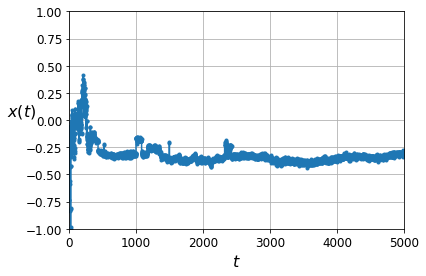

In [10]:
plot_series(X_train[0, :, 0], n_steps_training)

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(n_steps_ahead))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [12]:
history = model.fit(X_train, y_train, epochs=20,)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmphfob0t19.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmphfob0t19.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 3s 3s/step - loss: 0.7597 - last_time_step_mse: 0.5329
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.7081 - last_time_step_mse: 0.4155
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.6809 - last_time_step_mse: 0.3449
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.6627 - las

In [13]:


height_forecast = height_data['Height'].to_numpy()
height_forecast = np.interp(height_forecast, (height_forecast.min(), height_forecast.max()), (-1, +1))
height_forecast = height_forecast[n_steps_training-n_steps_forecast:n_steps_training+n_steps_ahead]

height_forecast_series = np.array([height_forecast])
height_forecast_series = height_forecast_series[..., np.newaxis].astype(np.float32)

X_new, Y_new = height_forecast_series[:, :n_steps_forecast], height_forecast_series[:, n_steps_forecast:]
X = X_new



In [14]:
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [15]:
print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

(1, 500, 1)
(1, 40, 1)
(1, 40, 1)


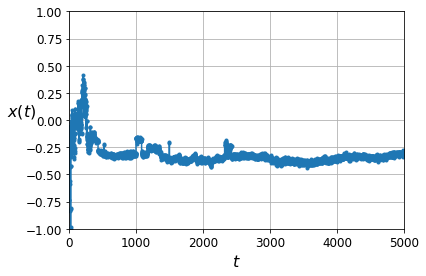

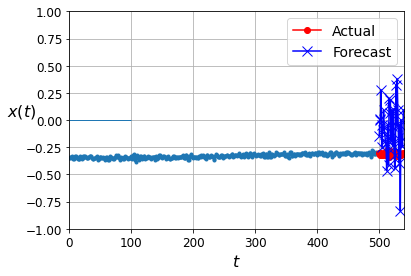

In [16]:
# Plot the entire training set 
plot_series(X_train[0, :, 0], n_steps_training)
plt.show()

# Plot the last n_step_forecast
plot_multiple_forecasts(X_new, Y_new, Y_pred, n_steps_forecast)
# save_fig("forecast_ahead_plot")
plt.show()



In [17]:
# Use a gaussian mixture to remove data points that are statistical outliers

In [18]:
# Calculate the seconds_since_epoch variable
original_data["seconds_since_epoch"] = original_data['Time'].astype(np.int64)

# Show all the keys (variable names) in the loaded data set
original_data.keys()

Index(['Time', 'Latitude', 'Longitude', 'Height', 'seconds_since_epoch'], dtype='object')

In [19]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height', 'seconds_since_epoch'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [20]:
# swap the order of the columns
columns_titles = ["seconds_since_epoch","Height"]
height_data=height_data.reindex(columns=columns_titles)

height_data.keys()

Index(['seconds_since_epoch', 'Height'], dtype='object')

In [21]:
# Define a pipline to clean numerical data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
#     ('std_scaler', StandardScaler()),
])

# Test that the pipeline works
height_data_imputed = num_pipeline.fit_transform(height_data)

height_data_imputed

array([[1.60945943e+18, 9.88267000e+02],
       [1.60945943e+18, 9.87801000e+02],
       [1.60945944e+18, 9.87804000e+02],
       ...,
       [1.60954559e+18, 9.88111000e+02],
       [1.60954559e+18, 9.88119000e+02],
       [1.60954560e+18, 9.88124000e+02]])

<AxesSubplot:xlabel='seconds_since_epoch', ylabel='Height'>

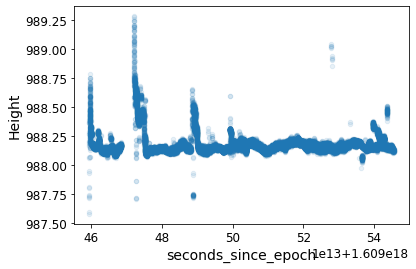

In [22]:
height_data.plot(kind="scatter", x="seconds_since_epoch", y="Height", alpha=0.1)

In [23]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    

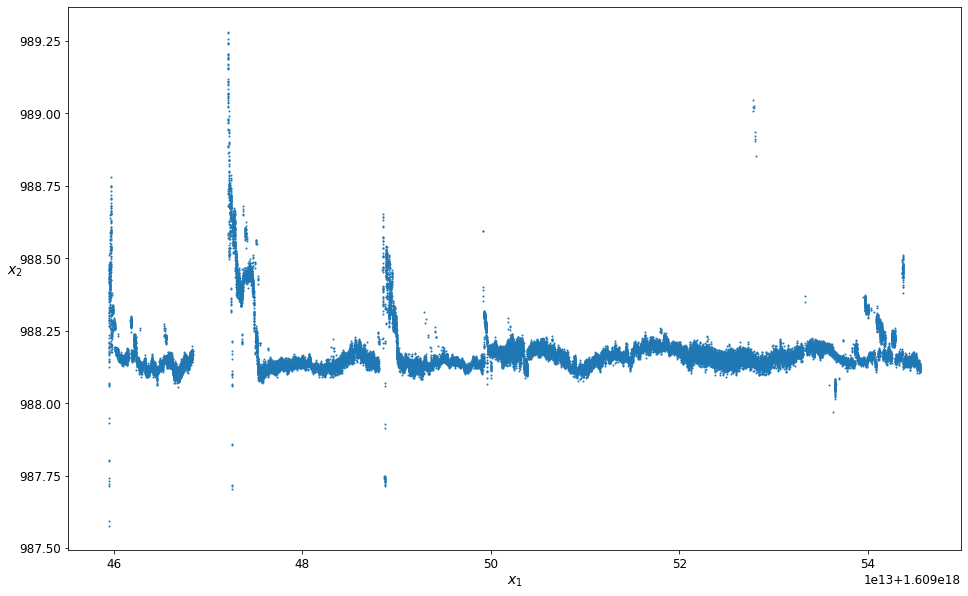

In [24]:
plt.figure(figsize=(16, 10))
plot_clusters(height_data_imputed)
plt.show()

In [25]:
from sklearn.mixture import GaussianMixture

In [26]:
N_COMPONENTS = 1
N_INIT = 10
COVARIANCE_TYPE = "tied"

gm = GaussianMixture(n_components=N_COMPONENTS, n_init=N_INIT,covariance_type=COVARIANCE_TYPE, random_state=42)
gm.fit(height_data_imputed)

GaussianMixture(covariance_type='tied', n_init=10, random_state=42)

In [27]:
gm.weights_

array([1.])

In [28]:
gm.means_

array([[1.60950381e+18, 9.88176262e+02]])

In [29]:
gm.means_

array([[1.60950381e+18, 9.88176262e+02]])

In [30]:
gm.covariances_


array([[ 5.32570008e+26, -2.08749500e+11],
       [-2.08749165e+11,  7.51011309e-03]])

In [31]:
gm.converged_

True

In [32]:
gm.n_iter_

2

In [33]:
gm.predict(height_data_imputed)

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
gm.predict_proba(height_data_imputed)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [35]:
height_data_new, y_new = gm.sample(6)
height_data_new

/usr/local/lib/python3.9/site-packages/sklearn/mixture/_base.py:431: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(mean, self.covariances_, int(sample))


array([[1.60949235e+18, 9.88168838e+02],
       [1.60948887e+18, 9.88313387e+02],
       [1.60950922e+18, 9.88153964e+02],
       [1.60946737e+18, 9.88256690e+02],
       [1.60951465e+18, 9.88218777e+02],
       [1.60951451e+18, 9.88131930e+02]])

In [36]:
y_new

array([0, 0, 0, 0, 0, 0])

In [37]:
gm.score_samples(height_data_imputed)

array([-32.3678671 , -42.38359734, -42.22552007, ..., -31.95606837,
       -31.90780404, -31.88204314])

In [38]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.0

In [39]:
from matplotlib.colors import LogNorm



def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

<ipython-input-39-0c652766f934>:33: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


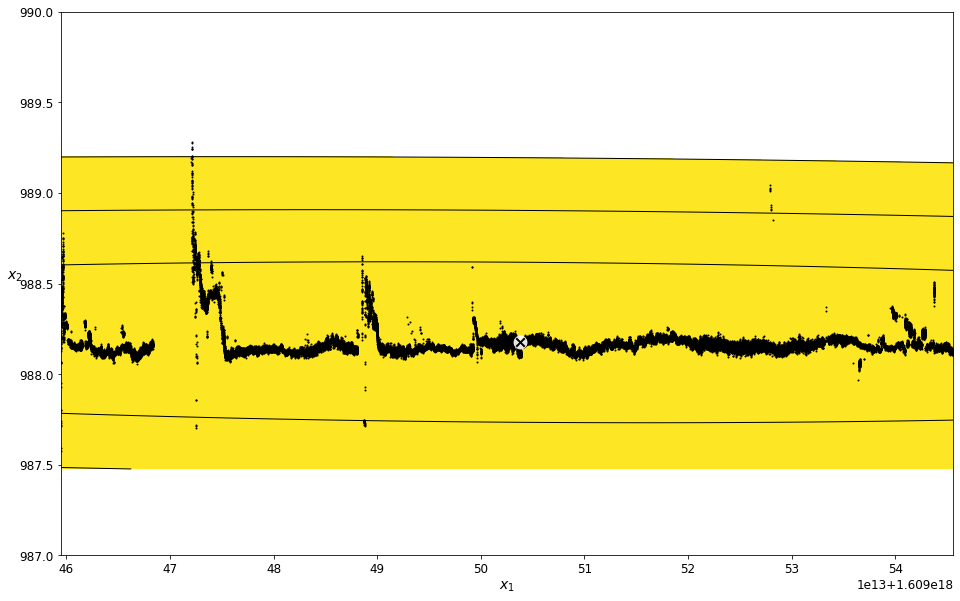

In [40]:
plt.figure(figsize=(16, 10))

plot_gaussian_mixture(gm, height_data_imputed)
plt.ylim(top=990, bottom=987)
# save_fig("gaussian_mixtures_plot")
plt.show()

<ipython-input-39-0c652766f934>:33: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


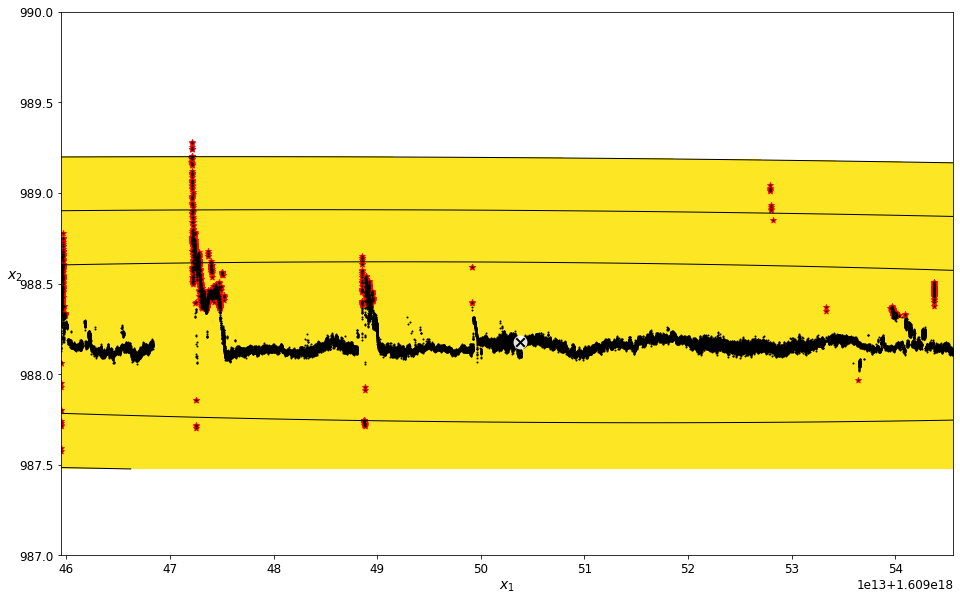

In [41]:
DENSITY_THRESHOLD_PERCENT = 5

densities = gm.score_samples(height_data_imputed)

density_threshold = np.percentile(densities, DENSITY_THRESHOLD_PERCENT)
anomalies = height_data_imputed[densities < density_threshold]



plt.figure(figsize=(16, 10))

plot_gaussian_mixture(gm, height_data_imputed)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=990, bottom=987)

# save_fig("mixture_anomaly_detection_plot")
plt.show()

<AxesSubplot:xlabel='seconds_since_epoch'>

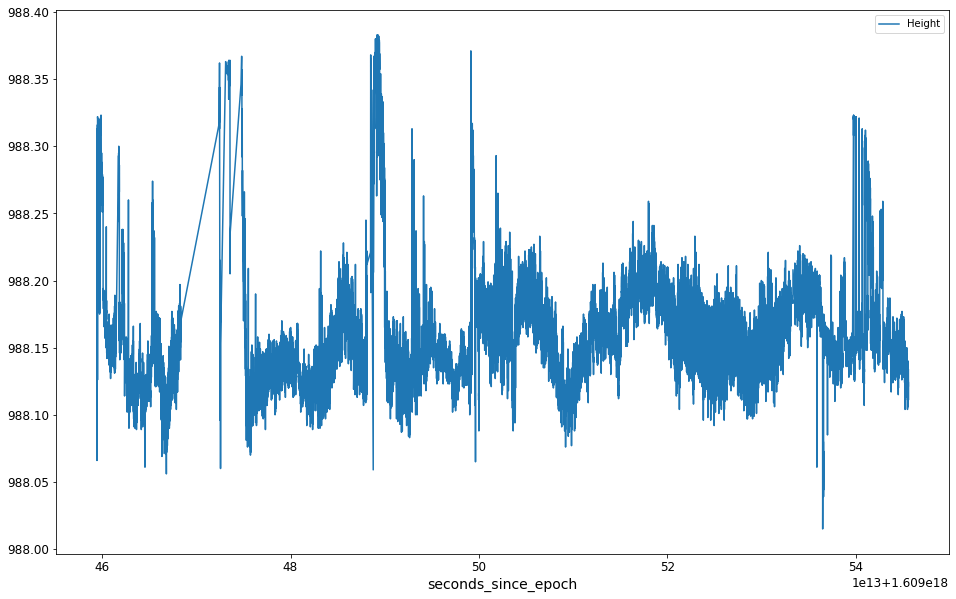

In [42]:
cleaned_data = height_data_imputed[densities >= density_threshold]
cleaned_pandas_data = pd.DataFrame(cleaned_data, columns = ['seconds_since_epoch','Height'])
cleaned_pandas_data.plot(x="seconds_since_epoch", y="Height",figsize=(16, 10))

In [43]:



# Need to make sure that the data sets are normalized at the same time

In [44]:
cleaned_height = cleaned_pandas_data['Height'].to_numpy()

# Rescale everything to the range between -1 and 1
cleaned_height = np.interp(cleaned_height, (cleaned_height.min(), cleaned_height.max()), (-1, +1))
cleaned_height = cleaned_height[:n_steps_training+1]

# height_series = height[..., np.newaxis].astype(np.float32)
cleaned_height_series = np.array([cleaned_height])
cleaned_height_series = cleaned_height_series[..., np.newaxis].astype(np.float32)

X_train = np.array(cleaned_height_series[:,:-1])
y_train = np.array(cleaned_height_series[:,-1])

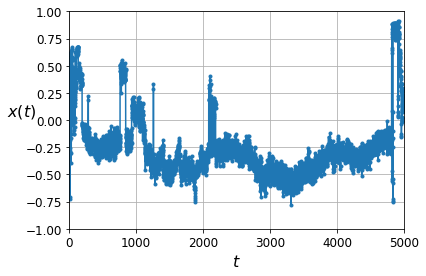

In [45]:
plot_series(X_train[0, :, 0], n_steps_training)

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(n_steps_ahead))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [47]:
cleaned_history = model.fit(X_train, y_train, epochs=20,)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.6792 - last_time_step_mse: 1.6084
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.6390 - last_time_step_mse: 1.5938
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.6032 - last_time_step_mse: 1.5763
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.5741 - last_time_step_mse: 1.5080
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.5481 - last_time_step_mse: 1.4115
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.5232 - last_time_step_mse: 1.3175
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.4993 - last_time_step_mse: 1.2302
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 0.4758 - last_time_step_mse: 1.1580
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 0.4540 - last_time_step_mse: 1.1009
Epoch 10/20
1/1 [==============================] - 2s 2

In [48]:
cleaned_height_forecast = cleaned_pandas_data['Height'].to_numpy()
cleaned_height_forecast = np.interp(cleaned_height_forecast, (cleaned_height_forecast.min(), cleaned_height_forecast.max()), (-1, +1))
cleaned_height_forecast = cleaned_height_forecast[n_steps_training-n_steps_forecast:n_steps_training+n_steps_ahead]

cleaned_height_forecast_series = np.array([cleaned_height_forecast])
cleaned_height_forecast_series = cleaned_height_forecast_series[..., np.newaxis].astype(np.float32)

X_new, Y_new = cleaned_height_forecast_series[:, :n_steps_forecast], cleaned_height_forecast_series[:, n_steps_forecast:]
X = X_new



In [49]:
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [50]:
print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

(1, 500, 1)
(1, 40, 1)
(1, 40, 1)


Saving figure forecast_ahead_plot


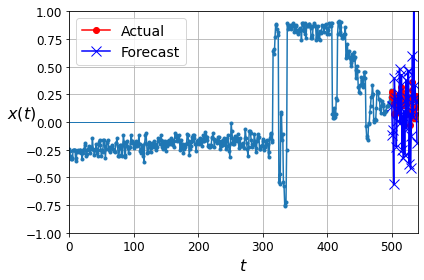

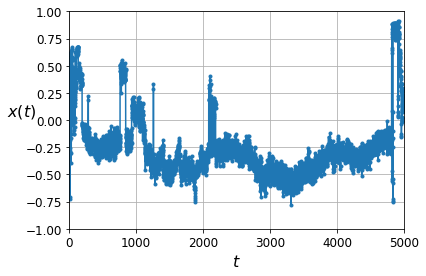

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred, n_steps_forecast)
save_fig("forecast_ahead_plot")
plt.show()

# Plot the entire training set for comparison
plot_series(X_train[0, :, 0], n_steps_training)